In [115]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.optimize import curve_fit

In [302]:
#Q0
def SABR_hagan(K, F, T, v, beta, rho, sig0):
    
    output = np.zeros(len(K))
    for i in range(len(K)):
        if F != K[i]:
            rr = 1 + ( (((1-beta)**2)/24)*((sig0**2)/(F*K[i])**(1-beta)) +
                      0.25*(rho*beta*v*sig0)/(F*K[i])**((1-beta)/2) +(2-3*rho**2)*(v**2)/24 )* T
    
            ld = (F*K[i])**((1-beta)/2)*(1 + ((1-beta)**2)*(np.log(F/K[i])**2)/24 +
                                         ((1-beta)**4)*(np.log(F/K[i])**4)/1920)
            z = (v/sig0)*(F*K[i])**((1-beta)/2)*np.log(F/K[i])
            x_z = np.log((np.sqrt(1-2*rho*z+z**2)+z-rho)/(1-rho))
            
            output[i] = sig0*(rr/ld)*(z/x_z) 
        else:
            rr = 1 + ( (((1-beta)**2)/24)*((sig0**2)/(F*K[i])**(1-beta)) +
                      0.25*(rho*beta*v*sig0)/(F*K[i])**((1-beta)/2) +(2-3*rho**2)*(v**2)/24 )* T
    
            ld = (F*K[i])**((1-beta)/2)*(1 + ((1-beta)**2)*(np.log(F/K[i])**2)/24 +
                                         ((1-beta)**4)*(np.log(F/K[i])**4)/1920)
            output[i] = sig0*(rr/ld)
      
    return output

In [303]:
F = 100
K = 100
beta = 0.7
sig = 0.1
rho = 0.5
T = 1
v = 1

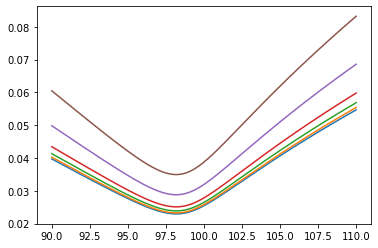

In [305]:
def draw_curve(T_):
    
    list_ = []
    K_list = np.linspace(90,110,1000)
    for K in K_list :
        list_.append(SABR_hagan([K], F, T_, v, beta, rho, sig))
    return list_

curve_=[]
for t in [.25,.5,1,2,5,10]:
    aa = draw_curve(t)
    curve_.append(aa)
    plt.plot(K_list,aa)

In [306]:
#Q1
from scipy.optimize import fsolve
mat = np.array([1/365, 7/365, 14/365, 30/365, 60/365, 90/365, 180/365, 1])
atm_col =np.array([10.99, 9.40, 8.68, 9.55, 10.14, 10.62, 11.52, 12.25]) /100
rr_col = np.array([-0.50, -0.60, -0.75, -1.00, -1.25, -1.52, -1.62, -1.75])/100
st_col = np.array([0.15, 0.15,0.15,0.17,0.23,0.25,0.35,0.40])/100

def atm_rate(t, sig ,spot, rf, rd):
    res = spot
    res *= np.exp(rf*t-rd*t)
    res *= np.exp(t*sig**2/2)
    return res

In [307]:
spot = 1.445
rf = 0.01
rd = 0.02
Ff = [forward(spot,rd,rf,t) for t in mat]
nn = len(mat)

In [322]:
#Used to calculate option price for given delta

def sig_VWB(sig_ATM, ST):
    return sig_ATM + ST

def forward(spot,rd,rf,t):
    return spot * np.exp((rd - rf) * t)

def sig_RR_P(sig_ATM,ST,RR):
    return  sig_VWB(sig_ATM, ST) - .5 * RR

def sig_RR_C(sig_ATM,ST,RR):
    return  sig_VWB(sig_ATM, ST) + .5 * RR


def calc_K_P(spot, sig, RR, ST, t, rf, rd):
    #####
    fd = forward(spot,rd,rf,t)
    exp = np.exp(sig * t**0.5 * norm.ppf(0.25*np.exp(t*0.01))+ 0.5* sig**2 * t)
    return fd * exp

def calc_K_C(spot, sig_ATM, RR, ST, t, rf, rd):
    sig_C = sig_VWB(sig_ATM, ST)+ RR
    fd = forward(spot,rd,rf,t)
    exp = np.exp(-sig_C * t**0.5 * norm.ppf(0.25*np.exp(t*0.01))+ 0.5* sig_C**2 * t)
    return fd * exp

In [323]:
atm = np.ones(nn)
rrc = np.ones(nn)
rrc_sig = np.ones(nn)
rrp = np.ones(nn)
rrp_sig = np.ones(nn)
stc = np.ones(nn)
stp = np.ones(nn)
st_sig = np.ones(nn)
for i in range(len(mat)):
    t = mat[i]
    sig = atm_col[i]
    atm[i] = atm_rate(t, sig ,spot, rf, rd)
    
    ST = st_col[i]
    RR = rr_col[i]
    
    rrc_sig[i] = sig_RR_C(sig,ST,RR)
    rrp_sig[i] = sig_RR_P(sig,ST,RR)
    rrp[i] = calc_K_P(spot, rrp_sig[i], RR, ST, t, rf, rd)
    rrc[i] = calc_K_C(spot, rrc_sig[i], RR, ST, t, rf, rd)
    st_sig[i] = sig_VWB(sig, ST)
    stc[i] = calc_K_C(spot, st_sig[i], RR, ST, t, rf, rd)
    stp[i] = calc_K_P(spot, st_sig[i], RR, ST, t, rf, rd)

data = np.array([atm,rrc,rrp,stc,stp,atm_col,rrp_sig,rrc_sig,st_sig])    
colnames = ['ATM stike','RR call strike','RR put strike','ST call strike','ST put strike','vol atm','vol by RR call',
           'vol by RR put', 'vol by ST']
df = pd.DataFrame( data.T,columns = colnames)


In [324]:
df

,ATM stike,RR call strike,RR put strike,ST call strike,ST put strike,vol atm,vol by RR call,vol by RR put,vol by ST
0,1.444984,1.450449,1.439266,1.450578,1.439392,0.1099,0.11390,0.10890,0.1114
1,1.444845,1.457312,1.432177,1.457727,1.432570,0.0940,0.09850,0.09250,0.0955
2,1.444655,1.460798,1.428323,1.461538,1.429012,0.0868,0.09205,0.08455,0.0883
3,1.444354,1.470245,1.418524,1.471718,1.419837,0.0955,0.10220,0.09220,0.0972
4,1.443846,1.483187,1.405983,1.485857,1.408229,0.1014,0.10995,0.09745,0.1037
5,1.443447,1.493408,1.395709,1.497462,1.398961,0.1062,0.11630,0.10110,0.1087
6,1.442604,1.524259,1.373403,1.530707,1.377976,0.1152,0.12680,0.11060,0.1187
7,1.441397,1.573082,1.345946,1.583789,1.352271,0.1225,0.13525,0.11775,0.1265


In [336]:
def cali(t ,f ,K_,sig_):
    
    def func_to_optimize(K_,v, beta, sig0):
        return  SABR_hagan(K_, f, t, v, beta, 0, sig0)
     
    popt, pcov = curve_fit(func_to_optimize, K_, sig_, p0 = [.5,.5,.5],bounds=((0,0,0),
                                                                               (np.inf,1,np.inf)), maxfev=10000)
      
    v = popt[0]
    beta = popt[1]
    sig0 = popt[2]
    return v, beta,sig0


In [337]:
# sig0 also parameter

vopt, betaopt, sopt=[],[],[]
for i in range(len(mat)):
    temp = cali(mat[i],Ff[i],
                 np.array([atm[i],rrc[i],rrp[i],stc[i],stp[i]]),
                 np.array([atm_col[i],rrc_sig[i],rrp_sig[i],st_sig[i],st_sig[i]]))
    vopt.append(temp[0])
    betaopt.append(temp[1])
    sopt.append(temp[2])


In [340]:
data2 = np.array([vopt,betaopt,sopt])
df2 = pd.DataFrame(data=data2.T,columns = ['v','beta','s'])
df2

,v,beta,s
0,8.907761,2.015718e-16,0.155614
1,3.797652,4.199140e-19,0.132254
2,3.049281,1.698373e-09,0.120914
3,2.226698,2.646417e-10,0.132215
4,1.752178,8.125009e-10,0.139121
5,1.531590,7.025635e-10,0.144466
6,1.113614,6.294381e-19,0.157125
7,0.835012,3.634330e-02,0.163961


In [329]:
# Q2
def delta(opt_type, t, rf, Fwd, K, sig):
    
    d = np.log(Fwd/K)+ .5 * sig**2 *t
    d1 = d/(sig*np.sqrt(t))
    
    if opt_type == 'call':
        w = 1
    else:
        w = -1
    
    return w * np.exp(-rf*t) * norm.cdf(w * d1)


In [346]:
def delta_3mo(K):
    sig_ = SABR_hagan(K, forward(spot,rd,rf,.25), .25, df2.iloc[-3,:][0], df2.iloc[-3,:][1], 0, df2.iloc[-3,:][2])
    return delta('call',.25,rf,forward(spot,rd,rf,.25), K, sig_)

In [347]:
lb = fsolve(lambda x : delta_3mo(x)-0.9 ,1.4)[0]
ub = fsolve(lambda x : delta_3mo(x)-0.1 ,1.4)[0]
period = np.linspace(lb,ub,1000)

Text(0.5, 1.0, 'sigma plot for 3 months maturity')

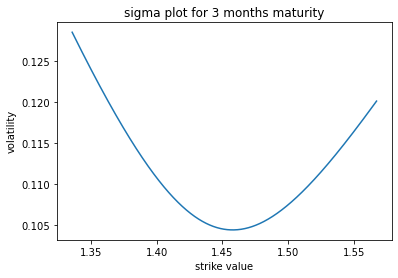

In [349]:
sig_pd = SABR_hagan(period, forward(spot,rd,rf,.25), .25, df2.iloc[-3,:][0], df2.iloc[-3,:][1], 0, df2.iloc[-3,:][2])
plt.plot(period,sig_pd)
plt.xlabel('strike value')
plt.ylabel('volatility')
plt.title('sigma plot for 3 months maturity')

In [445]:
# Q3
ImpVol=np.zeros(len(mat))
for i in range(len(mat)):
    ImpVol[i] = SABR_hagan([Ff[i]], Ff[i], .25, df2.iloc[i,:][0], df2.iloc[i,:][1], 0, df2.iloc[i,:][2])

In [446]:
ImpVol

array([0.28572015, 0.11901003, 0.09985458, 0.10087494, 0.10227681,
       0.10461452, 0.11101112, 0.11556196])

In [447]:
#Q4 Assume q is piecewise flat between each maturity


In [443]:
date = np.arange(1,181,1) # 1st stands for 3/10
matt = [1,7,14,30,60,90,180]
w_ = np.ones(180)

for i in range(180):
    if i % 7 == 2 or i % 7 == 3:
        w_[i] = 0


In [471]:
q_ = np.ones(len(matt))
ImpVol_adj = ImpVol.copy()
ImpVol_adj[0]=0.1099 #help to calibration, since the implied vol in 3 is too high
q_[0] = ImpVol_adj[0]
for i in range(1,7):
    adds = ImpVol_adj[i]**2*matt[i]-ImpVol_adj[i-1]**2*matt[i-1]
    q_[i] = np.sqrt(adds / sum(w_[matt[i-1]:matt[i]]))

In [477]:
vol_ = np.ones(180)
def cal_vol(t):
    rank = 1
    while t > matt[rank-1]:
        rank += 1
    temp = 0
    temp += matt[rank-2]* ImpVol_adj[rank-2]**2
    for i in range(matt[rank-2]-1,t+1):
        temp += w_[i-1]*q_[rank-1]**2
    
    return np.sqrt(temp/t)

Text(0, 0.5, 'Implied volatility')

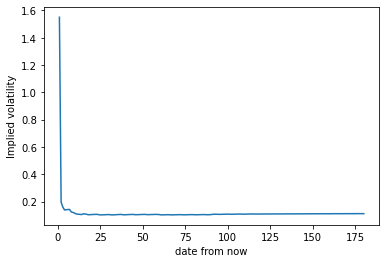

In [481]:
voll = [cal_vol(t) for t in date]
plt.plot(date,voll)
plt.xlabel('date from now')
plt.ylabel('Implied volatility')